In [2]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


# PacWhitesidedDolphin whale vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/PacWhitesidedDolphin


In [3]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import librosa

In [4]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn.visualization.spectrogram import visualize_spec, plot_spec
from avgn.utils.general import HParams
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.signalprocessing import spectrogramming as sg
import wave

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [5]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin')

In [6]:
DSLOC

PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin')

### load wavs

In [7]:
wavs = list(DSLOC.glob('*.wav'))
len(wavs), wavs[:3]

(4,
 [PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/._Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav'),
  PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav'),
  PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-FLIP0610-VLA-061018-210000.wav')])

In [8]:
wav_df = pd.DataFrame(columns = ['stem', 'path', 'rate'])
for wav in wavs:
    print(wav)
    try:
        with wave.open(wav.as_posix(), 'rb') as f:
            rate = f.getframerate()
        wav_df.loc[len(wav_df)] = [wav.stem, wav, rate]
    except:
        print('broken')
        continue

/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/._Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav
broken
/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav
/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-FLIP0610-VLA-061018-210000.wav
/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-CC0604-TAT08-060406-195843.wav


In [9]:
wav_df

,stem,path,rate
0,Lo-070421-164044-Lo-B16h40m44s21apr2007y,/mnt/cube/Datasets/mobysound/PacWhitesidedDolp...,192000
1,QX-Lo-FLIP0610-VLA-061018-210000,/mnt/cube/Datasets/mobysound/PacWhitesidedDolp...,192000
2,QX-Lo-CC0604-TAT08-060406-195843,/mnt/cube/Datasets/mobysound/PacWhitesidedDolp...,192000


### Load labels

In [10]:
click_types = [
    #['buzzd', '*buzzd.txt'],
    #['buzze', '*buzze.txt'],
    #['buzzf', '*buzzf.txt'],
    #['buzzg', '*buzzg.txt'],
    #['buzzh', '*buzzh.txt'],
    #['buzzd', '*buzzd.txt'],
    ['type 1', '*type 1.txt'],
    ['type 1a', '*type 1a.txt'],
    ['type 1b', '*type 1b.txt'],
    ['type 1c', '*type 1c.txt'],
    ['type 1d', '*type 1d.txt'],
    ['type 1e', '*type 1e.txt'],
    ['type 1f', '*type 1f.txt'],
    ['type 1g', '*type 1g.txt'],
    ['type 1h', '*type 1h.txt'],
    ['type 2', '*type 2.txt'],
    ['type 2b', '*type 2b.txt'],
    #['type 2c', '*type 2c.txt'],
    ['type 2d', '*type 2d.txt'],
    ['type 2e', '*type 2e.txt'],
    ['type 2f', '*type 2f.txt'],
    ['type 2g', '*type 2g.txt'],
    ['type 2h', '*type 2h.txt'],
]

In [11]:
clicks_df = []
for click_type, click_type_glob in click_types:
    good_clicks = list(DSLOC.glob(click_type_glob))
    for click_label_loc in good_clicks:
        try:
            good_clicks_df = pd.read_csv(click_label_loc, delimiter='\t')
        except:
            print(click_label_loc)
            continue
        good_clicks_df['stem'] = click_label_loc.stem
        good_clicks_df['click_value'] = click_type
        clicks_df.append(good_clicks_df)
clicks_df = pd.concat(clicks_df)
clicks_df.columns = [re.sub(' +', ' ', i) for i in clicks_df.columns]

/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-FLIP0610-VLA-061018-210000.type 2h.txt


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [12]:
len(clicks_df)

14137

In [13]:
clicks_df[:3]

,duration,end time,low freq,high freq,%,% start time,Unnamed: 3,Unnamed: 5,click_value,stem
0,0.01225,0.06098,1947.89357,95052.10643,NaN,0.04873,NaN,NaN,type 1,Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1
1,0.01342,0.27107,894.67849,93366.96231,NaN,0.25764,NaN,NaN,type 1,Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1
2,0.00992,0.46073,684.03548,94630.82040,NaN,0.45081,NaN,NaN,type 1,Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1


In [14]:
clicks_df.columns

Index([' duration', ' end time', ' low freq', ' high freq', '%',
       '% start time', 'Unnamed: 3', 'Unnamed: 5', 'click_value', 'stem'],
      dtype='object')

In [15]:
clicks_df.click_value.unique()

array(['type 1', 'type 1a', 'type 1b', 'type 1c', 'type 1d', 'type 1e',
       'type 1f', 'type 1g', 'type 1h', 'type 2', 'type 2b', 'type 2d',
       'type 2e', 'type 2f', 'type 2g', 'type 2h'], dtype=object)

In [16]:
"""nbins = 50
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].hist(clicks_df[" low freq"].values, bins=nbins, alpha=0.5, label="low freq")
axs[0].hist(clicks_df[" high freq"].values, bins=nbins, alpha=0.5, label="high freq")

for click_value in clicks_df.click_value.unique():
    axs[1].hist(
        clicks_df[clicks_df.click_value == click_value][" end time"].values
        - clicks_df[clicks_df.click_value == click_value]["% start time"].values,
        bins=nbins, normed = True, label=click_value, alpha = 0.5
    )
axs[0].legend()
axs[1].legend()"""

'nbins = 50\nfig, axs = plt.subplots(ncols=2, figsize=(15, 5))\naxs[0].hist(clicks_df[" low freq"].values, bins=nbins, alpha=0.5, label="low freq")\naxs[0].hist(clicks_df[" high freq"].values, bins=nbins, alpha=0.5, label="high freq")\n\nfor click_value in clicks_df.click_value.unique():\n    axs[1].hist(\n        clicks_df[clicks_df.click_value == click_value][" end time"].values\n        - clicks_df[clicks_df.click_value == click_value]["% start time"].values,\n        bins=nbins, normed = True, label=click_value, alpha = 0.5\n    )\naxs[0].legend()\naxs[1].legend()'

### get example click

In [17]:
click_row = clicks_df.iloc[1]

In [24]:
clicks_df[:3]

,duration,end time,low freq,high freq,%,% start time,Unnamed: 3,Unnamed: 5,click_value,stem
0,0.01225,0.06098,1947.89357,95052.10643,NaN,0.04873,NaN,NaN,type 1,Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1
1,0.01342,0.27107,894.67849,93366.96231,NaN,0.25764,NaN,NaN,type 1,Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1
2,0.00992,0.46073,684.03548,94630.82040,NaN,0.45081,NaN,NaN,type 1,Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1


In [25]:
click_row

 duration                                               0.01342
 end time                                               0.27107
 low freq                                               894.678
 high freq                                                93367
%                                                           NaN
% start time                                            0.25764
Unnamed: 3                                                  NaN
Unnamed: 5                                                  NaN
click_value                                              type 1
stem            Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1
Name: 1, dtype: object

In [26]:
click_row.stem

'Lo-070421-164044-Lo-B16h40m44s21apr2007y.type 1'

In [27]:
wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])

0     True
1    False
2    False
Name: stem, dtype: bool

In [28]:
??librosa.core.load

In [29]:
wav_loc

NameError: name 'wav_loc' is not defined

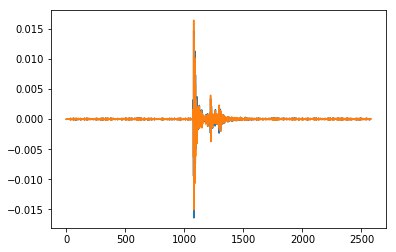

In [30]:
wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])].iloc[0]
wav_loc = wav_row.path

rate = wav_row.rate
data, rate = librosa.core.load(
    path=wav_loc,
    sr=None,
    offset=click_row["% start time"],
    duration=click_row[" end time"] - click_row["% start time"],
    mono=False,
    #dtype=np.float64
)
data = np.transpose(data[1])
click = butter_bandpass_filter(data, lowcut = 100, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)
click = butter_bandpass_filter(click, lowcut = 10000, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)

In [31]:
np.shape(data)

(2579,)

In [32]:
rate

192000

In [33]:
win_length_ms = .25
hop_length_ms = .02
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-80,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

48.0
3.8400000000000003


In [34]:
spectrogram = sg.spectrogram(click, hparams)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


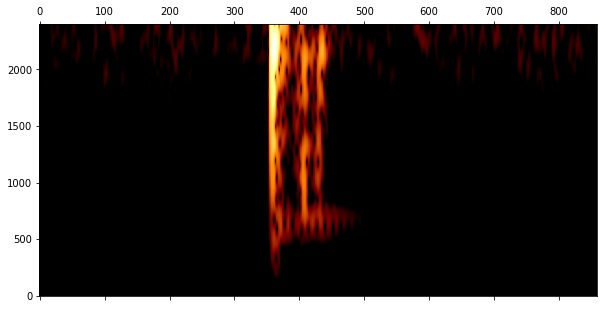

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [36]:
nrow = 3
ncol = 10
zoom_x = 3
zoom_y = 2

In [37]:
click_value_df.iloc[axi]

NameError: name 'click_value_df' is not defined

type 1e


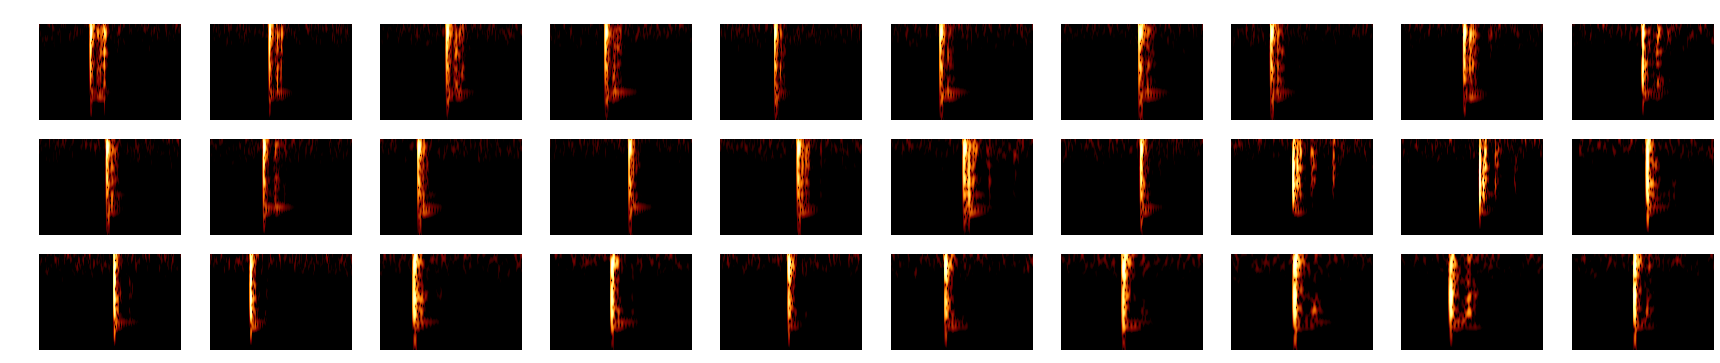

type 1f


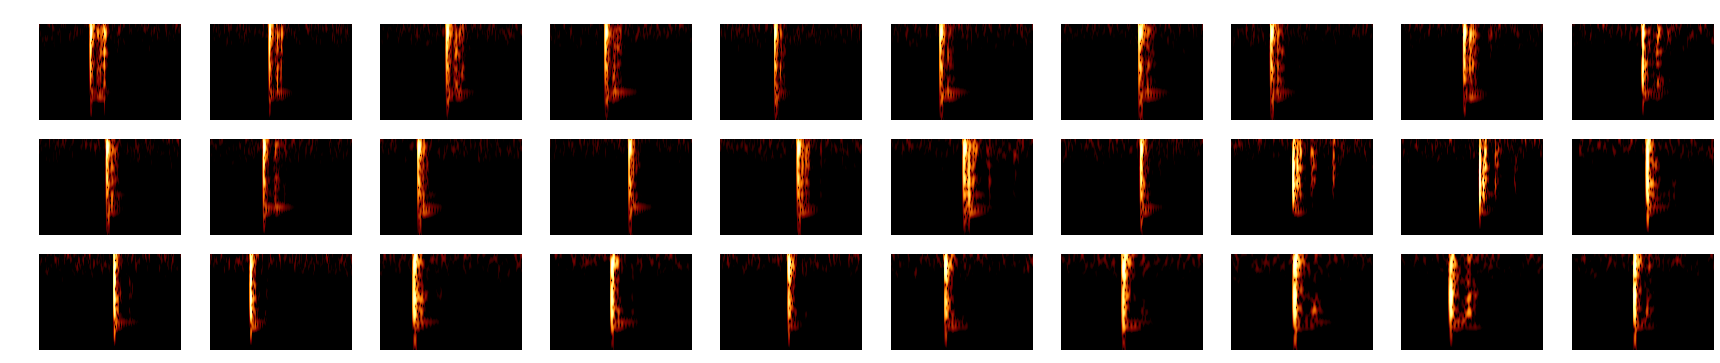

type 1g


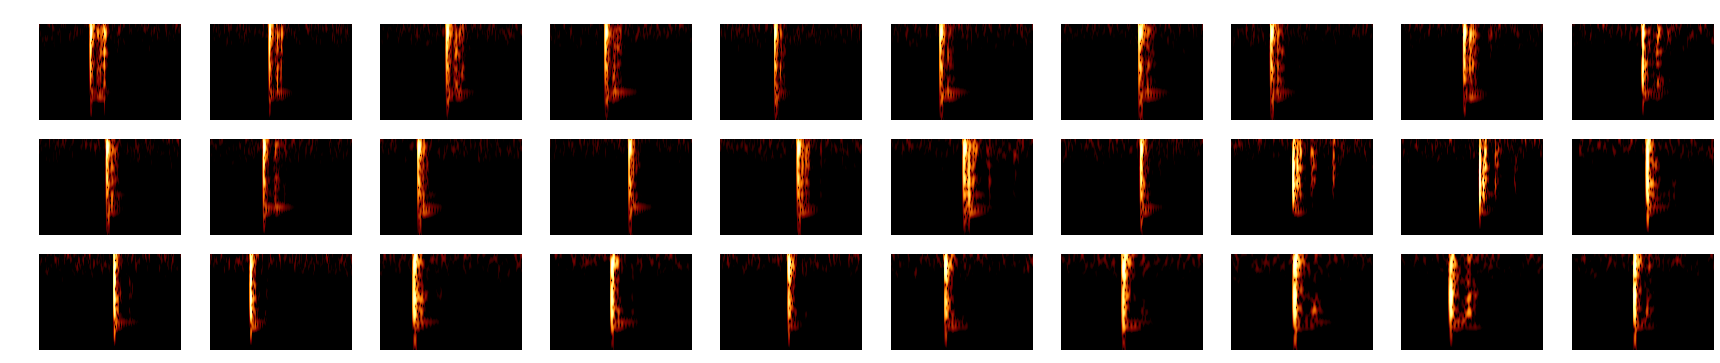

type 1h


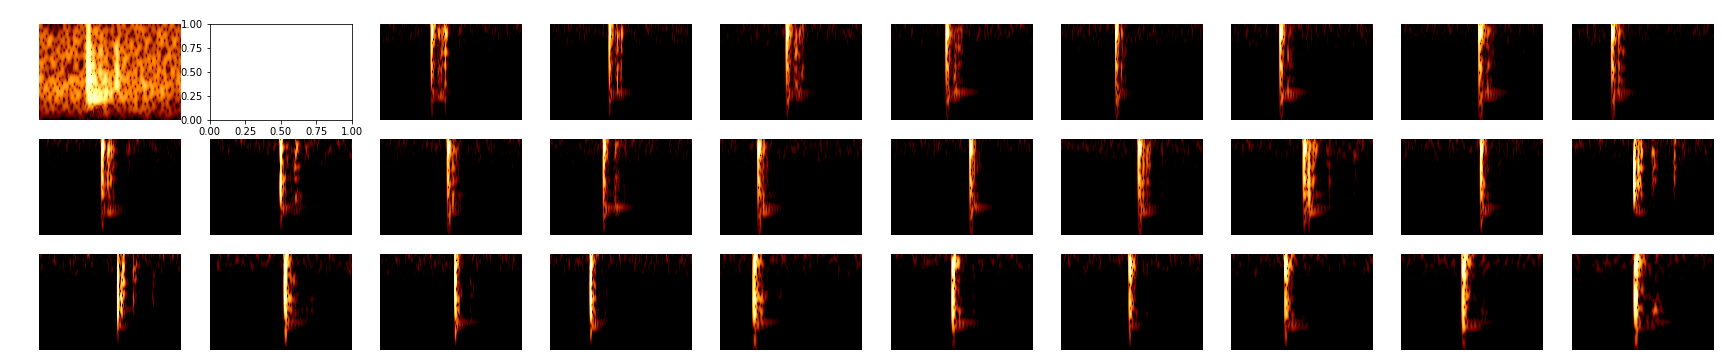

type 2


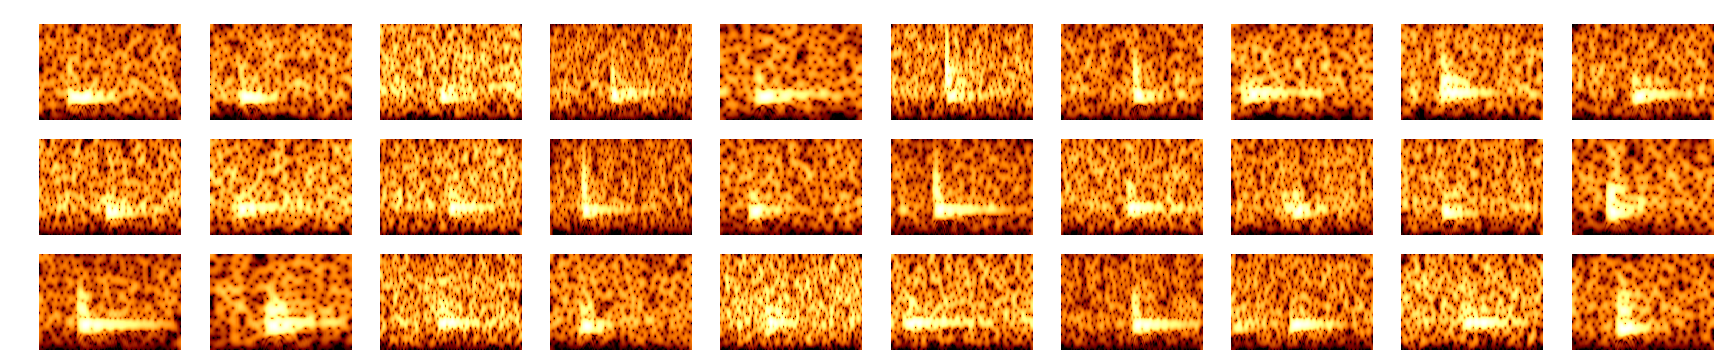

type 2b


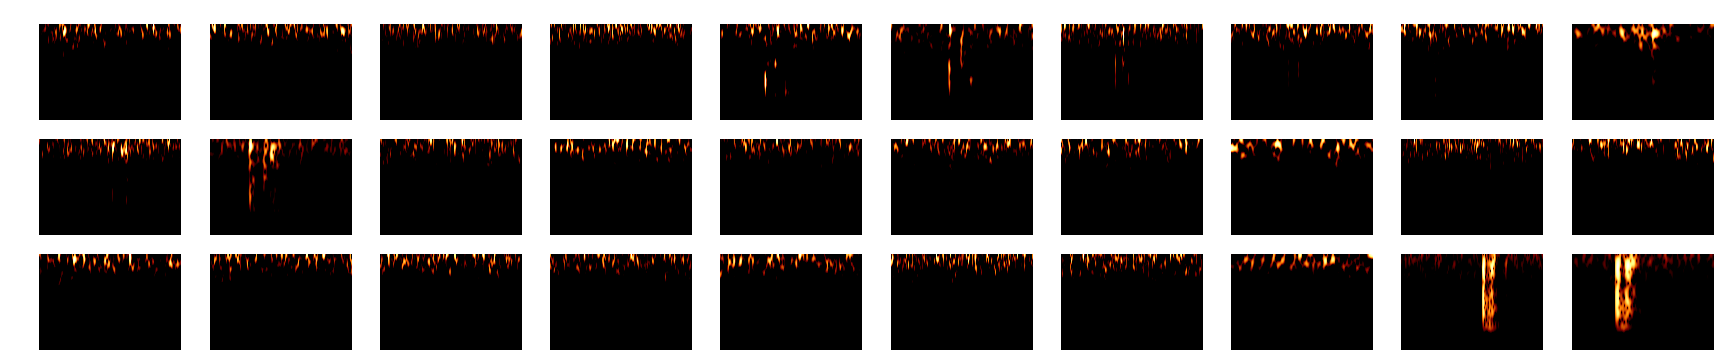

type 2d


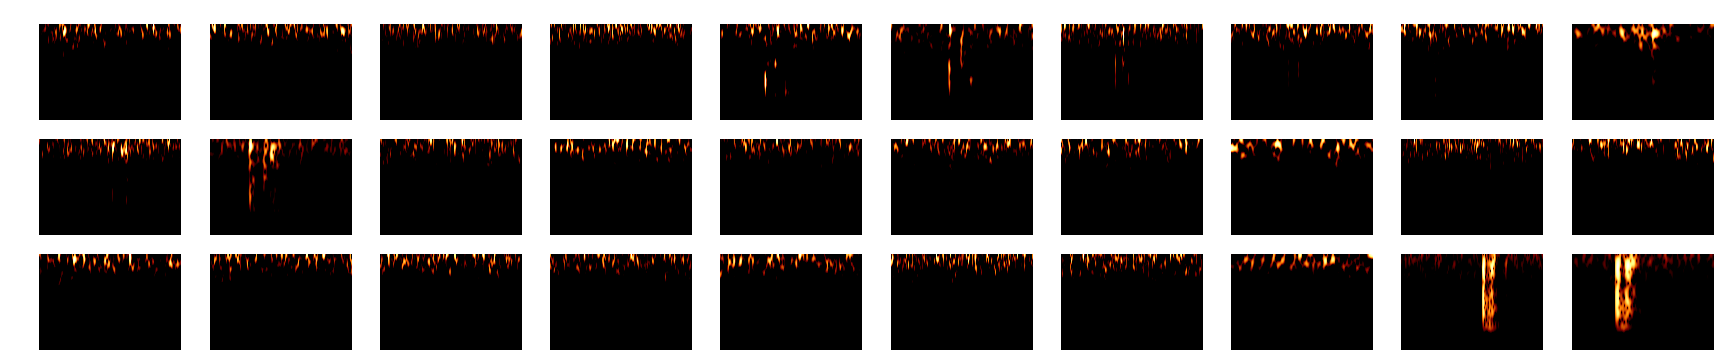

type 2e


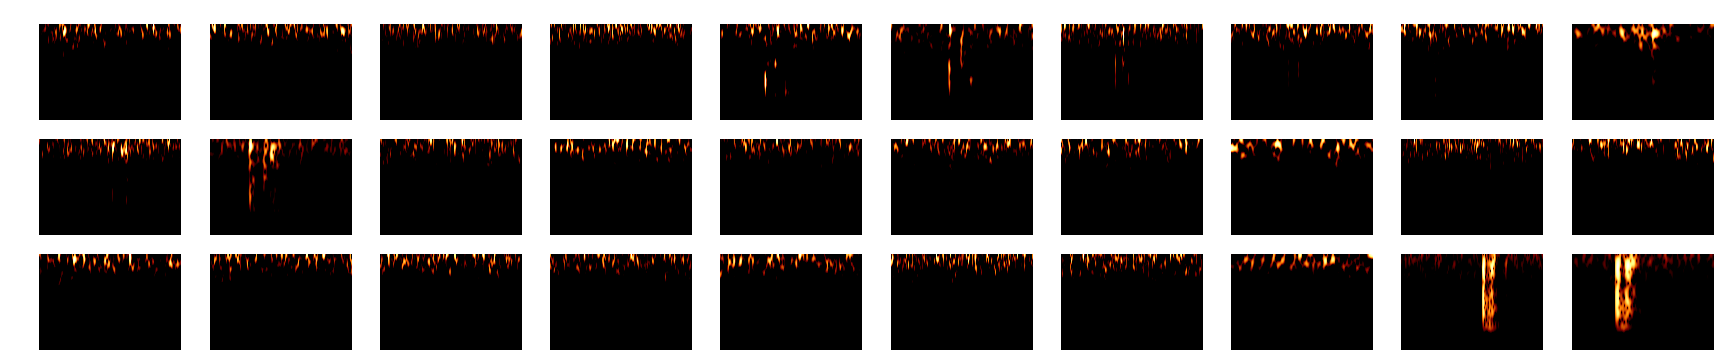

type 2f


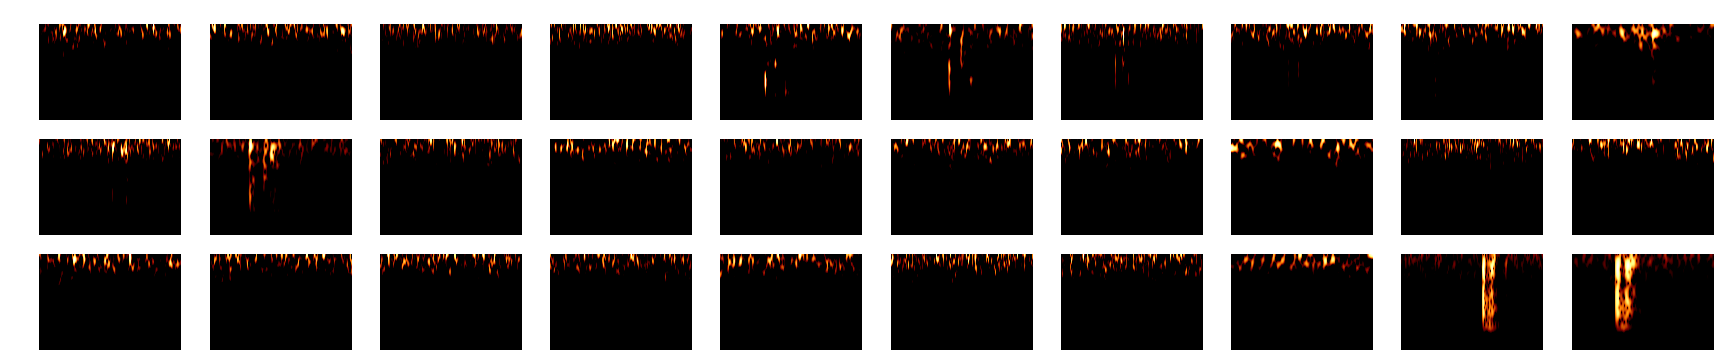

type 2g


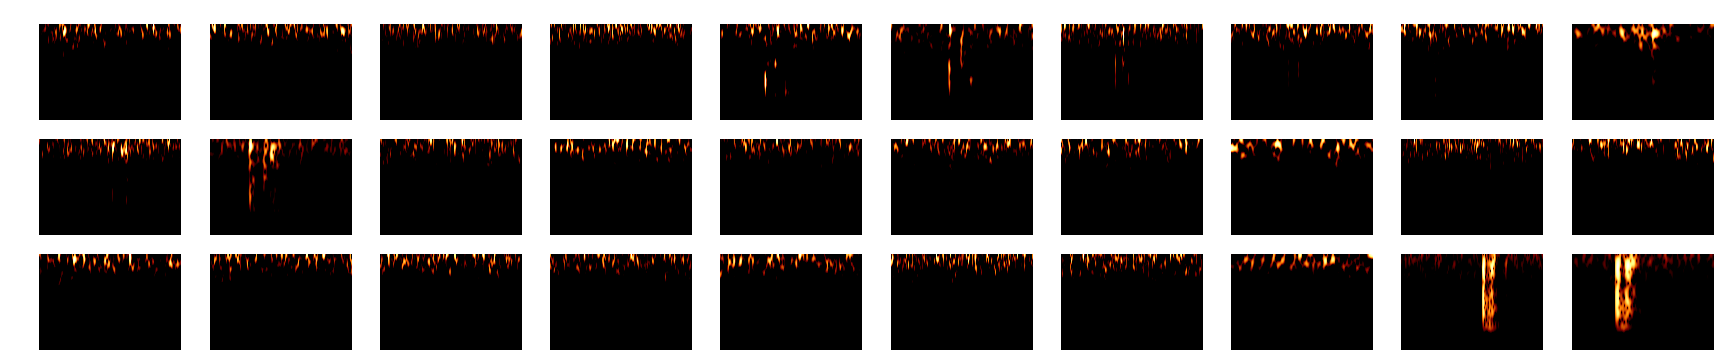

type 2h


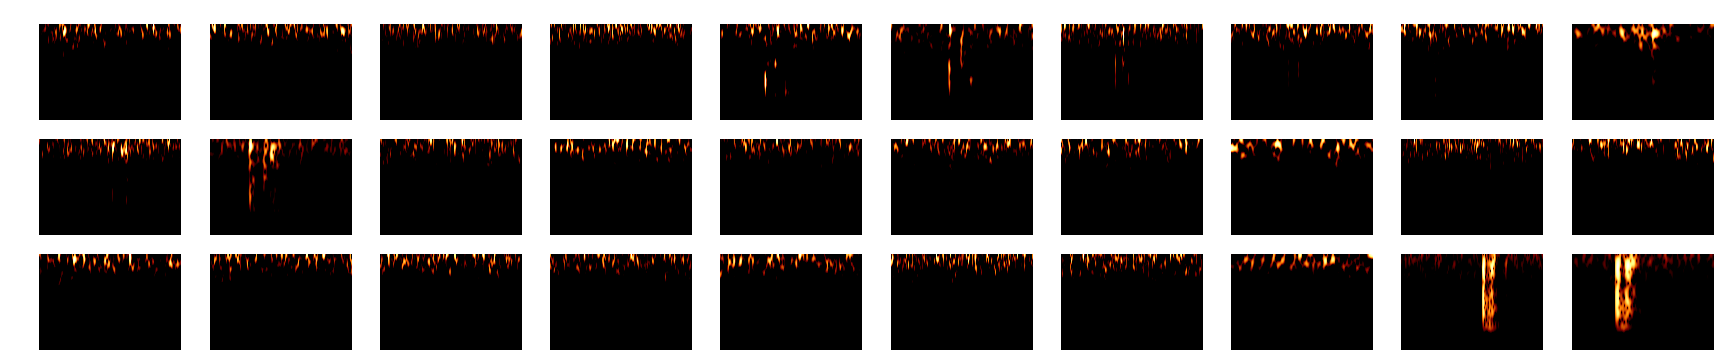

In [44]:
for click_value in clicks_df.click_value.unique()[5:]:
    print(click_value)
    click_value_df = clicks_df[clicks_df.click_value == click_value]
    fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
    for axi in tqdm(range(nrow*ncol)):    

        if axi >= len(click_value_df): continue
        click_row = click_value_df.iloc[axi]
        wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])].iloc[0]
        wav_loc = wav_row.path

        rate = wav_row.rate
        try:
            data, rate = librosa.core.load(
                path=wav_loc,
                sr=None,
                offset=float(click_row["% start time"]),
                duration=float(click_row[" end time"])- float(click_row["% start time"]),
                mono=False
            )
        except:
            continue
        data = np.transpose(data[1])

        #audio = int16_to_float32(data)
        audio = butter_bandpass_filter(data, lowcut = 500, highcut=int(rate/2)-2, fs=rate, order=4)
        spectrogram = sg.spectrogram(audio, hparams)
        #mel_spec = np.dot(spectrogram.T, mel_matrix).T
        ax = axs.flatten()[axi] 
        ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
        ax.axis('off')
    plt.show()

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [41]:
float(click_row[" end time"])

49.3125

In [42]:
float(click_row["% start time"])

49.30762